<a href="https://colab.research.google.com/github/czarodziejszyn/ssne/blob/main/projekt5/recursive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
import pickle
train_path = '/content/drive/MyDrive/ssne-recursive/train.pkl'
with open(train_path, 'rb') as f:
    data = pickle.load(f)

`data` jest postaci: `{(array([float, float, ..., float]), int), ...}`, gdzi tablica floatów to utwór, a int to oznaczenie kompozytora

In [18]:
print(f"Length: {len(data)}, Type: {type(data)}")
print(f"Length[0]: {len(data[0])}")
print(data[0])
print(len(data[0][0]))
print(data[0][0][0])

Length: 2939, Type: <class 'list'>
Length[0]: 2
(array([ -1.,  -1.,  -1., ...,  78.,  40., 144.]), 0)
4756
-1.0


In [19]:
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import numpy as np

In [20]:
BATCH_SIZE = 32
INPUT_SIZE = 1
NUM_LAYERS = 1
HIDDEN_SIZE = 5
NUM_CLASSES = 5

In [21]:
import math

min_val = math.inf
max_val = -math.inf

for x in data:
    for elt in x[0]:
        if elt < min_val:
            min_val = elt
        if elt > max_val:
            max_val = elt

for i in range(len(data)):
    for j in range(len(data[i][0])):
        data[i][0][j] = np.float32((data[i][0][j] - min_val) / max_val)

In [22]:
from sklearn.model_selection import train_test_split

tensor_data = [(torch.tensor(x[0], dtype=torch.float32), x[1]) for x in data]
train_data, test_data = train_test_split(tensor_data, test_size=0.2, random_state=42)

In [23]:
def collate_fn(batch):
    (xx, yy) = zip(*batch)
    x_lens = [len(x) for x in xx]
    max_length = max(x_lens)

    padded_xx = [torch.cat([x, torch.zeros(max_length - len(x))]) for x in xx]

    return torch.stack(padded_xx), torch.tensor(yy)

In [24]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [25]:
composers = {0: 'bach', 1: 'beethoven', 2: 'debussy', 3: 'scarlatti', 4: 'victoria'}

In [26]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, out_size, dropout=0.3):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1

        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=False,
            dropout=dropout,
            bidirectional=self.bidirectional
        )

        self.layer_norm = nn.LayerNorm(hidden_size * self.num_directions)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * self.num_directions, out_size)

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size)
        return (c0, h0)

    def forward(self, x, hidden):
        rnn_out, hidden = self.rnn(x, hidden)
        last_time_step = rnn_out[-1]
        normed = self.layer_norm(last_time_step)
        dropped = self.dropout(normed)
        out = self.fc(dropped)
        return out, hidden

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = RNNClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
model

cuda


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


RNNClassifier(
  (rnn): LSTM(1, 5, dropout=0.3, bidirectional=True)
  (layer_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=10, out_features=5, bias=True)
)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

for epoch in range(101):
    model.train()
    total_loss = 0

    for x, targets in train_loader:
        x = x.to(device).unsqueeze(2)  # Shape: (batch_size, seq_len, 1) => Transpose next
        x = x.transpose(0, 1)  # Shape: (seq_len, batch_size, input_size)
        targets = targets.to(device).long()

        hidden = model.init_hidden(x.size(1))  # batch_size = x.size(1)
        hidden = tuple(h.to(device) for h in hidden)

        preds, _ = model(x, hidden)

        optimizer.zero_grad()
        loss = loss_fun(preds, targets)
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch}, Loss: {total_loss / len(train_loader):.4f}")


Epoch: 0, Loss: 1.4641
Epoch: 10, Loss: 1.2981
Epoch: 20, Loss: 1.2608
Epoch: 30, Loss: 1.2918
Epoch: 40, Loss: 1.2699
Epoch: 50, Loss: 1.2588
Epoch: 60, Loss: 1.2710
Epoch: 70, Loss: 1.2660
Epoch: 80, Loss: 1.2521
Epoch: 90, Loss: 1.2663
Epoch: 100, Loss: 1.2516


Test Accuracy: 57.82%, Test Loss: 1.223


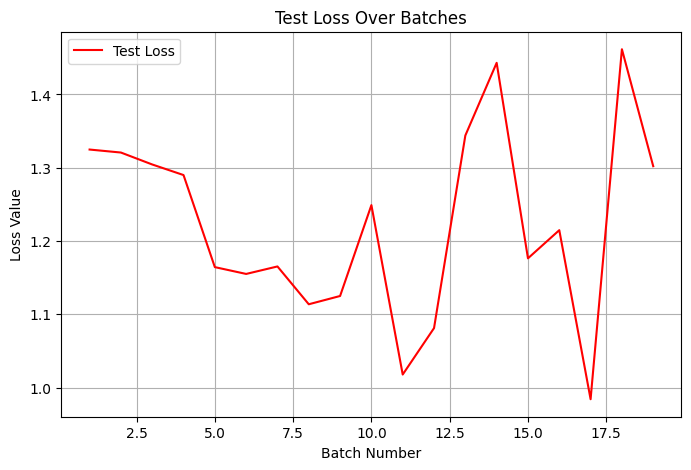

In [33]:
import matplotlib.pyplot as plt

def evaluate(model, test_loader, loss_fun, device):
    model.eval()
    total_correct = 0
    total_samples = 0
    loss_values = []

    with torch.no_grad():
        for x, targets in test_loader:
            x = x.to(device).unsqueeze(2)
            x = x.transpose(0, 1)
            targets = targets.to(device)

            hidden = model.init_hidden(x.size(1))
            hidden = tuple(h.to(device) for h in hidden)

            preds, _ = model(x, hidden)

            loss = loss_fun(preds, targets)
            loss_values.append(loss.item())

            _, predicted = torch.max(preds, dim=1)
            total_correct += (predicted == targets).sum().item()
            total_samples += targets.size(0)

    accuracy = total_correct / total_samples * 100
    avg_loss = sum(loss_values) / len(loss_values)

    print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {avg_loss:.3f}")
    return loss_values, accuracy

loss_values, test_accuracy = evaluate(model, test_loader, loss_fun, device)

epochs = list(range(1, len(loss_values) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, label="Test Loss", color="red")
plt.xlabel("Batch Number")
plt.ylabel("Loss Value")
plt.title("Test Loss Over Batches")
plt.legend()
plt.grid()
plt.show()